## MS Star-Forming Galaxy Diagnostic Using IR Spectra

This notebook provides detailed instructions on how to apply the diagnostic tool for identifying main-sequence (MS) star-forming galaxies based on their infrared (IR) spectra.

### Available Functions

- `calculate_flux_in_range()`: Computes the flux within a specified wavelength range.
This function takes 3 argunments: The wavelgth, the flux density, and the classification mdel (weights)
- `MS_SF_diagnostic()`: Applies the diagnostic model to the input spectra to classify MS star-forming galaxies. This function is callled by the first fucntion automatically, there is no need for any input by the user <br>
Below, we apply our diagnotic on an example spectra from the S5 survey.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from astropy.table import Table
from scipy.interpolate import PchipInterpolator
import joblib

In [2]:
def calculate_flux_in_range(wavelength, flux, wavelength_min, wavelength_max):
    # Calculate the flux in the specified wavelength range
    index_min = np.argmin(np.abs(wavelength - wavelength_min))
    index_max = np.argmin(np.abs(wavelength - wavelength_max))

    int_flux = np.trapezoid(flux[index_min:index_max], wavelength[index_min:index_max])
    return int_flux

In [3]:
def MS_SF_diagnostic(wavelength, flux, clf):
    x = wavelength
    y = flux/wavelength**2
    spl2 = PchipInterpolator(x, y)
    xs = np.linspace(min(x), max(x),500)
    bands = {"PAH1" : [59500,65500], # 6.2um
             "PAH2" : [72000,89000], # 7.7um + 8.6um
             "PAH3" : [109000,118100], # 11.3um
             "Cont215" : [210000,220000]} # continuum
    
    if ((min(x) < 5.90) & (max(x) > 22.0)):
        fts = []
        for bnd in bands:
            fts.append(calculate_flux_in_range(xs*10**4, spl2(xs)*10**4,bands[bnd][0],bands[bnd][1]))
        df_ftrs = pd.DataFrame([fts],columns=list(bands.keys()))

        df_ftrs['pah1_noftrs'] = np.log10(df_ftrs['PAH1']/df_ftrs['Cont215'].astype(float))
        df_ftrs['pah2_noftrs'] = np.log10(df_ftrs['PAH2']/df_ftrs['Cont215'].astype(float))
        df_ftrs['11p3_cont'] = np.log10(df_ftrs['PAH3']/df_ftrs['Cont215'].astype(float))
                
        cls = clf.predict(df_ftrs[['pah1_noftrs','pah2_noftrs','11p3_cont']])[0]
        if cls == 1: return 'SFG'
        else: return 'NOT-SFG'
    else : return np.na # Not Classified

### The spectrum must be in rest frame, the in flux density in Jy, and the wavelegth in Angstorms

In [ ]:
# import model weights
clf = joblib.load('path-to/MSMIRdiagnostic_model.joblib')

### Application on an example spectrum from the [NASA/IPAC Infrared Science Archive](https://irsa.ipac.caltech.edu/frontpage/) <br>
The spectrum an br found [here](https://irsa.ipac.caltech.edu/data/SPITZER/S5/observations/S5_15_3.html)

In [ ]:
file_path = 'path-to/S5_15_3_lores.tbl'
table = Table.read(file_path, format='ascii')
df = table.to_pandas()
df

,wavelength,flux_density,ERROR,cl1,cl2,cl3
0,5.12652,0.003523,0.002565,1.0,0,0
1,5.15676,0.006035,0.003526,1.0,0,0
2,5.18700,0.001247,0.001797,1.0,0,0
3,5.21725,0.001869,0.000992,1.0,0,0
4,5.24749,0.001232,0.000818,1.0,0,0
...,...,...,...,...,...,...
372,39.21839,0.103689,0.022736,4.0,0,0
373,39.38774,0.063616,0.019189,4.0,0,0
374,39.55709,0.056337,0.025472,4.0,0,0
375,39.72645,-0.033165,0.035628,4.0,0,0


In [6]:
# YOU ONLY NEED THIS IF THE SPECTRUM IS NOT IN REST-FRAME
z = 0.056
df['wavelength'] = df['wavelength']/(1+z)

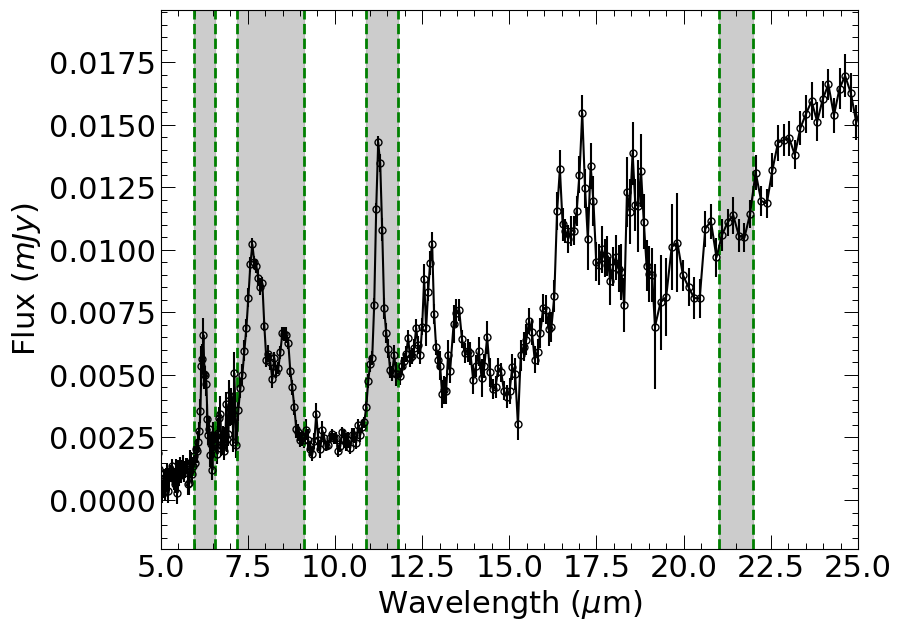

In [ ]:
fig, ax1 = plt.subplots(figsize=(9, 7))

ax1.errorbar(df['wavelength'], df['flux_density'], yerr=df['ERROR'],c='k', fmt='-o',markerfacecolor='none', markeredgecolor='k',markersize=5,label='IRS obs')

plt.xlabel('Wavelength $(\\mu$m)',fontsize=22)
plt.ylabel('Flux $(mJy)$',fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
bands = {"PAH1": [59500,65500], # 6.2um 
         "PAH2": [72000,91000], # 7.7um + 8.6um
         "PAH3" : [109000,118100],
         "Cont215" : [210000,220000]} # No features

band_names = list(bands.keys())

for bnd in band_names:
    band_midpoint = (bands[bnd][0] + bands[bnd][1]) / 2
    ax1.axvspan(10**-4*bands[bnd][0], 10**-4*bands[bnd][1], alpha=0.4, color='grey') 
    ax1.axvline(x=10**-4*bands[bnd][0],linestyle ="--",c='g',linewidth=2)
    ax1.axvline(x=10**-4*bands[bnd][1],linestyle ="--",c='g',linewidth=2)
    
band_midpoint = (bands['PAH1'][0] + bands['PAH1'][1]) / 2.
ax1.annotate('PAH1', xy=(10**-4*band_midpoint, 250), xycoords='data', ha='center', rotation=90, color='g', fontsize=14)
band_midpoint = (bands['PAH2'][0] + bands['PAH2'][1]) / 2.
ax1.annotate('PAH2', xy=(10**-4*band_midpoint, 320), xycoords='data', ha='center', rotation=90, color='g', fontsize=14)
band_midpoint = (bands['PAH3'][0] + bands['PAH3'][1]) / 2.
ax1.annotate('PAH3', xy=(10**-4*band_midpoint, 375), xycoords='data', ha='center', rotation=90, color='g', fontsize=14)
band_midpoint = (bands['Cont215'][0] + bands['Cont215'][1]) / 2.
ax1.annotate('Cont215', xy=(10**-4*band_midpoint, 300), xycoords='data', ha='center', rotation=90, color='g', fontsize=14)

ax1.minorticks_on()
ax1.tick_params(axis = "x", direction = "in", length = 10, width = 0.7, top = True, bottom=True)
ax1.tick_params(axis = "x", which='minor', direction = "in", length=4, width = 0.7, color='k', top = True, bottom=True)
ax1.tick_params(axis = "y", direction = "in", length = 10, width = 0.7, right = True, left=True)
ax1.tick_params(axis = "y", which='minor', direction = "in", length=4, width = 0.7, color='k', right = True, left=True)

x_min, x_max = 5, 25
visible = (df['wavelength'] >= x_min) & (df['wavelength'] <= x_max)

y_min = (df.loc[visible, 'flux_density'] - df.loc[visible, 'ERROR']).min()
y_max = (df.loc[visible, 'flux_density'] + df.loc[visible, 'ERROR']).max()

y_range = y_max - y_min
y_pad = 0.1 * y_range
ax1.set_xlim(5, 25)
ax1.set_ylim(y_min - y_pad, y_max + y_pad)
plt.show()

### Classification result:

In [8]:
MS_SF_diagnostic(df['wavelength'],df['flux_density'],clf)

'SFG'

In [9]:
### EOF ###